# Backtesting a Trading Strategy with MarginTrader

## Contents

* [Overview of MarginTrader](#mt-overview)
* [Running a Backtest](#backtest)
    * [Backtesting on one instrument](#backtesting-on-one-trading-instrument)
    * [Inspecting backtest results](#inspecting-backtest-results)
    * [Backtesting on multiple instruments](#backtesting-on-multiple-trading-instruments)
* [Analysing Strategy Performance with Pyfolio](#analysing-backtest-results-with-pyfolio)

## Overview of MarginTrader <a id="mt-overview"></a>

MarginTrader is a backtesting framework for simulating CFD trading in Python. The following are things to note about the current state of the framework:

* Only market orders can be submitted.
* Orders are executed without any slippage assumptions.
* Orders are rejected only if there isn't enough margin to execute the order.
* Broker account simulation is based trading through brokers that use the MetaTrader5 platform.

## Running a Backtest <a id="backtest"></a>
The following four components are required to conduct a backtest with MarginTrader:

1. Data Handler: for managing how data flows through the system.
2. Broker: for simulating order execution and position handling on a brokage account.
3. Strategy: for writing the strategy logic and interacting with the rest of the system.
4. Trader: for running the system.

MarginTrader provides three backtest data handlers: CSV, Pandas, and Yahoo data handlers. In this example, we'll use the CSV data handler.

We'll backtest a momentum strategy that buy when the current bar's close price exceeds the previous bar's close price and sell when the opposite occurs. The strategy will be tested using one-year historical data for Apple and Microsoft stocks from March 7, 2023 to March 7, 2024.

In [1]:
from margin_trader.broker import SimBroker
from margin_trader.data_handlers import HistoricCSVDataHandler
from margin_trader.strategy import Strategy
from margin_trader.trader import Trader
from margin_trader.constants import OrderSide

### Backtesting on one trading instrument
To write a strategy component for the backtesting, subclass the `Strategy` class and override the `on_market` method. The strategy and order creation logic should be defined or called in the `on_market` method, which is called whenever new market data is received by the system.

In [2]:
DATA_PATH = "../data"   # Path to CSV file
SYMBOLS = ["AAPL"]      # Name(s) of CSV files (AAPL.csv)

In [3]:
class Momentum(Strategy):
    prev_price = None

    def on_market(self):
        curr_price = self.data_handler.get_latest_price(self.symbols[0])
        position = self.broker.get_position(self.symbols[0])
        signal = self.calculate_signal(curr_price)
        self.prev_price = curr_price

        if signal:
            if position:
                # If we are already in a position in the same direction, don't place any
                # orders
                if position.side == signal:
                    return
                else:
                    if signal == OrderSide.BUY:  # Reverse sell position
                        self.broker.buy(symbol=self.symbols[0], units=2 * position.units)
                    else:  # Reverse buy position
                        self.broker.sell(symbol=self.symbols[0], units=2 * position.units)
            else:
                if signal == OrderSide.BUY:
                    self.broker.buy(symbol=self.symbols[0])
                else:
                    self.broker.sell(symbol=self.symbols[0])

    def calculate_signal(self, price):
        if self.prev_price:
            if price > self.prev_price:
                return OrderSide.BUY
            return OrderSide.SELL
        return None

In [4]:
# Create the trading components
data_handler = HistoricCSVDataHandler(csv_dir=DATA_PATH, symbols=SYMBOLS)
sim_broker = SimBroker(
    balance=100_000,
    leverage=1,
    commission=3.0,  # Transaction cost for opening and closing trades.
    exec_price="current",  # Execute trades at current close price
)
strategy = Momentum(
    symbols=SYMBOLS,  # Symbols to trade.
)
trader = Trader(data_handler=data_handler, broker=sim_broker, strategy=strategy)

# Run the strategy
trader.run()

Starting backtest
Finished running backtest


### Inspecting Backtest Results
After the backtest simulation is completed, an `account_history` dictionary gets added to the Trader instance. The `account_history` has the following keys:

* balance_equity: a dataframe containing historical account balances and equity values.
* positions: a dataframe containing historical positions.
* orders: a data frame containing historical orders.

We can use this dataframes to inspect if the expected trades were executed or not.

In [5]:
# Checking the first daily bars
trader.data_handler.latest_symbol_data["AAPL"][:5]

[AAPL(Index=Timestamp('2023-03-07 00:00:00'), open=153.699997, high=154.029999, low=151.130005, close=151.600006),
 AAPL(Index=Timestamp('2023-03-08 00:00:00'), open=152.809998, high=153.470001, low=151.830002, close=152.869995),
 AAPL(Index=Timestamp('2023-03-09 00:00:00'), open=153.559998, high=154.539993, low=150.229996, close=150.589996),
 AAPL(Index=Timestamp('2023-03-10 00:00:00'), open=150.210007, high=150.940002, low=147.610001, close=148.5),
 AAPL(Index=Timestamp('2023-03-13 00:00:00'), open=147.809998, high=153.139999, low=147.699997, close=150.470001)]

In [6]:
trader.account_history["positions"].head()

,symbol,side,units,open_price,close_price,commission,pnl,open_time,close_time,id
0,AAPL,buy,100,152.869995,150.589996,6.0,-233.9999,2023-03-08,2023-03-09,1
1,AAPL,sell,100,150.589996,150.470001,6.0,5.9995,2023-03-09,2023-03-13,2
2,AAPL,buy,100,150.470001,155.000000,6.0,446.9999,2023-03-13,2023-03-17,3
3,AAPL,sell,100,155.000000,157.399994,6.0,-245.9994,2023-03-17,2023-03-20,4
4,AAPL,buy,100,157.399994,157.830002,6.0,37.0008,2023-03-20,2023-03-22,5


In [7]:
trader.account_history["orders"].head()

,timestamp,symbol,order_type,units,side,price,sl,tp,status,order_id,position_id,request
0,2023-03-08,AAPL,mkt,100,buy,None,None,None,executed,1,1,open
1,2023-03-09,AAPL,mkt,100,sell,None,None,None,executed,2,1,close
2,2023-03-09,AAPL,mkt,100,sell,None,None,None,executed,2,2,open
3,2023-03-13,AAPL,mkt,100,buy,None,None,None,executed,3,2,close
4,2023-03-13,AAPL,mkt,100,buy,None,None,None,executed,3,3,open


### Backtesting on multiple trading instruments
To use a strategy for two or more assets, loop through all the available symbols in the strategy instance and apply the trading logic on each of them.

In [8]:
class Momentum(Strategy):
    def __init__(self, symbols):
        super().__init__(symbols)
        self.prev_price = {symbol: None for symbol in self.symbols}

    def on_market(self):
        for symbol in self.symbols:
            self.trade(symbol)

    def trade(self, symbol):
        curr_price = self.data_handler.get_latest_price(symbol)
        position = self.broker.get_position(symbol)
        signal = self.calculate_signal(symbol, curr_price)
        self.prev_price[symbol] = curr_price

        if signal:
            if position:
                if position.side == signal:
                    return
                else:
                    if signal == OrderSide.BUY:
                        self.broker.buy(symbol=symbol, units=2 * position.units)
                    else:
                        self.broker.sell(symbol=symbol, units=2 * position.units)
            else:
                if signal == OrderSide.BUY:
                    self.broker.buy(symbol=symbol)
                else:
                    self.broker.sell(symbol=symbol)

    def calculate_signal(self, symbol, curr_price):
        prev_price = self.prev_price[symbol]
        if prev_price:
            if curr_price > prev_price:
                return OrderSide.BUY
            return OrderSide.SELL
        return None

In [9]:
SYMBOLS = ["AAPL", "MSFT"]
data_handler = HistoricCSVDataHandler(csv_dir=DATA_PATH, symbols=SYMBOLS)
sim_broker = SimBroker(commission=3.0)
strategy = Momentum(symbols=SYMBOLS)
trader = Trader(data_handler=data_handler, broker=sim_broker, strategy=strategy)
trader.run()

Starting backtest
Finished running backtest


In [10]:
display(
    trader.data_handler.latest_symbol_data["AAPL"][:5],
    trader.data_handler.latest_symbol_data["MSFT"][:5],
    trader.account_history["positions"].head(10),
    trader.account_history["orders"].head(10)
)

[AAPL(Index=Timestamp('2023-03-07 00:00:00'), open=153.699997, high=154.029999, low=151.130005, close=151.600006),
 AAPL(Index=Timestamp('2023-03-08 00:00:00'), open=152.809998, high=153.470001, low=151.830002, close=152.869995),
 AAPL(Index=Timestamp('2023-03-09 00:00:00'), open=153.559998, high=154.539993, low=150.229996, close=150.589996),
 AAPL(Index=Timestamp('2023-03-10 00:00:00'), open=150.210007, high=150.940002, low=147.610001, close=148.5),
 AAPL(Index=Timestamp('2023-03-13 00:00:00'), open=147.809998, high=153.139999, low=147.699997, close=150.470001)]

[MSFT(Index=Timestamp('2023-03-07 00:00:00'), open=256.299988, high=257.690002, low=253.389999, close=254.149994),
 MSFT(Index=Timestamp('2023-03-08 00:00:00'), open=254.039993, high=254.539993, low=250.809998, close=253.699997),
 MSFT(Index=Timestamp('2023-03-09 00:00:00'), open=255.820007, high=259.559998, low=251.580002, close=252.320007),
 MSFT(Index=Timestamp('2023-03-10 00:00:00'), open=251.080002, high=252.789993, low=247.600006, close=248.589996),
 MSFT(Index=Timestamp('2023-03-13 00:00:00'), open=247.399994, high=257.910004, low=245.729996, close=253.919998)]

,symbol,side,units,open_price,close_price,commission,pnl,open_time,close_time,id
0,AAPL,buy,100,152.869995,150.589996,6.0,-233.9999,2023-03-08,2023-03-09,1
1,AAPL,sell,100,150.589996,150.470001,6.0,5.9995,2023-03-09,2023-03-13,3
2,MSFT,sell,100,253.699997,253.919998,6.0,-28.0001,2023-03-08,2023-03-13,2
3,AAPL,buy,100,150.470001,155.000000,6.0,446.9999,2023-03-13,2023-03-17,4
4,AAPL,sell,100,155.000000,157.399994,6.0,-245.9994,2023-03-17,2023-03-20,6
5,MSFT,buy,100,253.919998,272.230011,6.0,1825.0013,2023-03-13,2023-03-20,5
6,MSFT,sell,100,272.230011,273.779999,6.0,-160.9988,2023-03-20,2023-03-21,8
7,AAPL,buy,100,157.399994,157.830002,6.0,37.0008,2023-03-20,2023-03-22,7
8,MSFT,buy,100,273.779999,272.290009,6.0,-154.9990,2023-03-21,2023-03-22,9
9,AAPL,sell,100,157.830002,158.929993,6.0,-115.9991,2023-03-22,2023-03-23,10


,timestamp,symbol,order_type,units,side,price,sl,tp,status,order_id,position_id,request
0,2023-03-08,AAPL,mkt,100,buy,None,None,None,executed,1,1,open
1,2023-03-08,MSFT,mkt,100,sell,None,None,None,executed,2,2,open
2,2023-03-09,AAPL,mkt,100,sell,None,None,None,executed,3,1,close
3,2023-03-09,AAPL,mkt,100,sell,None,None,None,executed,3,3,open
4,2023-03-13,AAPL,mkt,100,buy,None,None,None,executed,4,3,close
5,2023-03-13,AAPL,mkt,100,buy,None,None,None,executed,4,4,open
6,2023-03-13,MSFT,mkt,100,buy,None,None,None,executed,5,2,close
7,2023-03-13,MSFT,mkt,100,buy,None,None,None,executed,5,5,open
8,2023-03-17,AAPL,mkt,100,sell,None,None,None,executed,6,4,close
9,2023-03-17,AAPL,mkt,100,sell,None,None,None,executed,6,6,open


## Analysing backtest results with Pyfolio
Pyfolio is a portfolio analysis tool for generating various statistical metrics from historical data of financial assets returns and trades.

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import pyfolio as pf
from margin_trader.performance.utils import get_pyfolio_roundtrips

In [13]:
rts = get_pyfolio_roundtrips(trader.account_history)
equity_rets = trader.account_history["balance_equity"]["equity"].pct_change().fillna(0)

In [14]:
pf.round_trips.print_round_trip_stats(rts)

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,244.00,122.00,122.00
Percent profitable,0.35,0.31,0.39
Winning round_trips,86.00,38.00,48.00
Losing round_trips,158.00,84.00,74.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$955.00,$-8101.00,$9056.00
Gross profit,$39278.00,$14742.00,$24536.00
Gross loss,$-38323.00,$-22843.00,$-15480.00
Profit factor,$1.02,$0.65,$1.59
Avg. trade net profit,$3.91,$-66.40,$74.23
Avg. winning trade,$456.72,$387.95,$511.17
Avg. losing trade,$-242.55,$-271.94,$-209.19
Ratio Avg. Win:Avg. Loss,$1.88,$1.43,$2.44
Largest winning trade,$3082.00,$1575.00,$3082.00
Largest losing trade,$-1072.00,$-1072.00,$-890.00


Duration stats,All trades,Short trades,Long trades
Avg duration,2 days 23:48:11.803278688,2 days 19:16:43.278688524,3 days 04:19:40.327868852
Median duration,2 days 00:00:00,2 days 00:00:00,3 days 00:00:00
Longest duration,13 days 00:00:00,10 days 00:00:00,13 days 00:00:00
Shortest duration,0 days 00:00:00,1 days 00:00:00,0 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,-0.07%,0.08%
Avg returns winning,0.45%,0.39%,0.51%
Avg returns losing,-0.24%,-0.27%,-0.21%
Median returns all round_trips,-0.07%,-0.11%,-0.06%
Median returns winning,0.28%,0.27%,0.31%
Median returns losing,-0.19%,-0.23%,-0.16%
Largest winning trade,3.00%,1.54%,3.00%
Largest losing trade,-1.08%,-1.08%,-0.86%


Symbol stats,AAPL,MSFT
Avg returns all round_trips,0.02%,-0.01%
Avg returns winning,0.32%,0.60%
Avg returns losing,-0.16%,-0.31%
Median returns all round_trips,-0.06%,-0.13%
Median returns winning,0.22%,0.43%
Median returns losing,-0.13%,-0.25%
Largest winning trade,1.54%,3.00%
Largest losing trade,-0.52%,-1.08%


Start date,2023-03-07
End date,2024-03-07
Total months,12
,Backtest
Annual return,0.951%
Cumulative returns,0.955%
Annual volatility,8.779%
Sharpe ratio,0.15
Calmar ratio,0.12
Stability,0.06
Max drawdown,-8.112%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.11,2023-11-08,2023-12-12,NaT,NaN
1,4.05,2023-03-17,2023-05-25,2023-07-17,87
2,3.06,2023-07-25,2023-10-04,2023-11-06,75
3,0.73,2023-03-10,2023-03-13,2023-03-14,3
4,0.56,2023-07-18,2023-07-19,2023-07-20,3


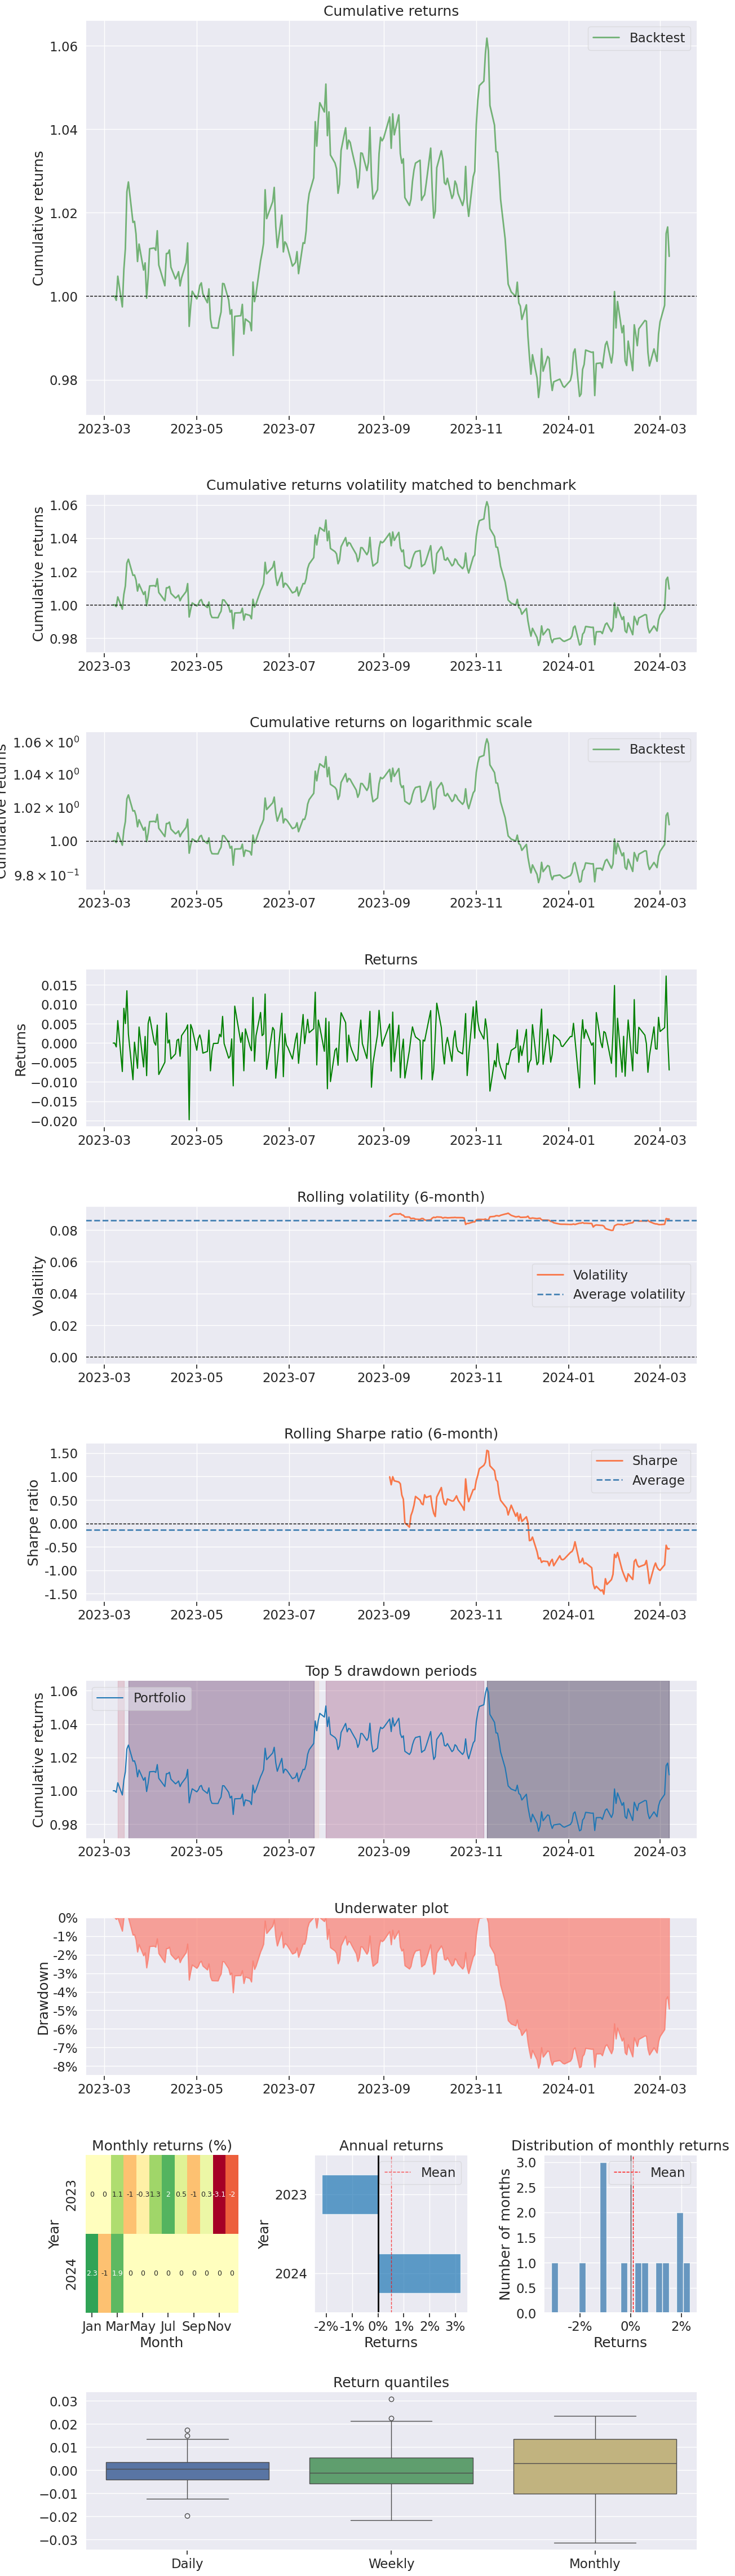

In [15]:
pf.create_returns_tear_sheet(equity_rets)

## References

* https://www.quantstart.com/articles/Event-Driven-Backtesting-with-Python-Part-I/
* https://github.com/stefan-jansen/pyfolio-reloaded